In [3]:
import re
from Bio import SeqIO
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statistics

## Get byte string for chromosome 2

In [15]:
seq_ = 0
seq_string = ""
human_genome = SeqIO.parse("files/GCA_000001405.28_GRCh38.p13_genomic.fna", "fasta")
for chromosome in human_genome:
    if chromosome.name == "CM000664.2":
        seq_ = str(chromosome.seq).lower().encode('utf8')
        break

## The sequence began and ended with just ns, so so to prove that first and last 10000 bps are just ns I've printed count of ns

In [17]:
# Counting ns at the beginning and end of the string
print("number of ns in first 10000 bases: ",seq_[:10000].count(b'n'))
print("number of ns in last 10000 bases: ",seq_[-10000:].count(b'n'))

number of ns in first 10000 bases:  10000
number of ns in last 10000 bases:  10000


## Remove first 9999 and last 9999 ns, i.e just leave one n before and after sequence

In [6]:
#seq_string = seq_string[9999:-9999] 

seq_ = seq_[9999:-9999] #first and last 10000 bps are n's but will leave one n at the beginning and one n at the end.

## Methods to get sha and hash values

In [7]:
from hashlib import sha256
p = 2_549_536_629_329
bits_48 = 2 ** 48 - 1
scale = 0x07ffffffff

def getshavalues(subseq):
    return int(sha256(subseq).hexdigest(), 16) % bits_48
def hash_fn(sha_value,a):
    return ((sha_value * a) % p) & scale

#### Since I'd been tinkering with multiprocessing and this process takes a lot of time I thought it would be prudent to take all sha values in a list first even though I take extra memory here, I could have instead directly calculated hash value here rather than storing it in a list.
#### **I've rewritten the corrected code after the "Run over all sha values in lst_finalb" section. Tests for the code follow that section

In [ ]:
# One pass quicker method to achieve the splits
# Using a list here instead of np array since np array append creates a copy of the list while list append adds to the original list. Will convert the final list of sha values to an np array.
def getNmers(seq_,interval = 15):
    seqb_sha_values = []
    counter_ = 0
    for i in range(len(seq_) - interval + 1):
        nmerb = seq_[i:i+interval]
        counter_+=1
        #print(nmer)
        if((nmerb.count(b"n")>2)):
            # print(nmer)
            # print(nmerb)
            pass
        else:
            nmerb_sha = getshavalues(nmerb)
            seqb_sha_values.append(nmerb_sha) ## I could have just run the hash value estimation part here and not save this as an array, however I wanted to tinker with multiprocessing and also see what the true value comes out to be so went with this instead.
    return seqb_sha_values,counter_

lst_finalb,sequence_count = getNmers(seq_)

In [34]:
print("Total nmers with more than 2 ns included:",sequence_count)
print("Total 15mers with duplicates but without nmers with >2ns :",len(lst_finalb))

Total nmers with more than 2 ns included: 242173517
Total 15mers with duplicates but without nmers with >2ns : 240548029


In [35]:
## Convert lst_finalb to np array
lst_finalb = np.array(lst_finalb,int)

In [141]:
avg_method = []
estimates_method = []
for i in tqdm(range(100)):
    sample_sha_vals = np.random.choice(lst_finalb,100)
    min_hashes = []
    for i in range(1,101):
        min_ = np.inf
        for j in sample_sha_vals:
            hshval = hash_fn(j,i)
            hshval/=scale
            if(hshval<min_):
                #print(hshval," i ",i)
                min_ = hshval
        min_hashes.append(min_)
    min_hashes = sorted(min_hashes)
    estimates_ = [(1/min_hash) -1 for min_hash in min_hashes]
    median_estimate = statistics.median(estimates_)
    estimates_method.append(median_estimate)
    mean_val = len(min_hashes)/sum(min_hashes) - 1
    avg_method.append(mean_val)
print("Thus estimate based on inverse of average hash value is:", statistics.mean(avg_method))
print("Thus estimate based on median of estimate of each individual hash value is:", statistics.mean(estimates_method))

  0%|          | 0/100 [00:00<?, ?it/s]

Thus estimate based on inverse of average hash value is: 101.83709212553349
Thus estimate based on median of estimate of each individual hash value is: 150.6541031693754


## Run over all sha values in lst_finalb

In [36]:
min_hashes = []
for i in tqdm(range(1,101)):
    min_ = np.inf
    for j in lst_finalb:
        hshval = hash_fn(j,i)
        hshval/=scale
        if(hshval<min_):
            #print(hshval," i ",i)
            min_ = hshval
    min_hashes.append(min_)



  0%|          | 0/100 [00:00<?, ?it/s]

## **Corrected code bypassing the need for lst_finalb

In [13]:

def getNmers_updated(seq_,interval = 15,disable_ = False):
    min_hashes = np.full((100,1),np.inf)
    counter_ = 0
    for i in tqdm(range(len(seq_) - interval + 1),disable = disable_):
        nmerb = seq_[i:i+interval]
        
        #print(nmer)
        if((nmerb.count(b"n")>2)):
            # print(nmer)
            # print(nmerb)
            pass
        else:
            counter_+=1
            nmerb_sha = getshavalues(nmerb)
            for a in range(1,101):
                hshval = hash_fn(nmerb_sha,a)
                hshval/=scale
                if(hshval < min_hashes[a-1]):
                    min_hashes[a-1] = hshval
            
    return min_hashes,counter_

## Run test for getNmers_updated, will run for randomly selected sequence of 10000 base pairs

## Ran the test 100 times and take mean of values generated in the tests. I used the following 2 methods to test:
#### For the test I thought I should randomly take sample of 10000 base pairs from seq_, compute the 100 hashes for each sha value, and for each hash function we store the minimum most value, 

#### To estimate unique elements one test is we take the average of these hash values, subtract one from inverse of average and see how deviated that value is from unique sequences calculated using getNmers_test.

#### The other test is to calculate estimate based on each hash value, and take median of these values.

* method 1: 1/avg(hash_values) - 1
* method 2: median(1/hash_value - 1 for all hash_values)

####  Having lst_finalb above could be really helpful in this regard since then I know exactly how many unique hashes are there.

In [ ]:
## Function to get true value of sequences without duplicates
def getNmers_test(seq_,interval = 15):
    nmer_vals = []
    counter_ = 0
    for i in range(len(seq_) - interval + 1):
        nmerb = seq_[i:i+interval]
        counter_+=1
        #print(nmer)
        if((nmerb.count(b"n")>2)):
            # print(nmer)
            # print(nmerb)
            pass
        else:
            #nmerb_sha = getshavalues(nmerb)
            nmer_vals.append(nmerb) ## I could have just run the hash value estimation part here and not save this as an array, however I wanted to tinker with multiprocessing and also see what the true value comes out to be so went with this instead.
    return len(set(nmer_vals)),counter_



In [14]:
avg_method = []
estimates_method = []
control_vals = []
for test_num in tqdm(range(100)):
    upr_bound = int(np.random.uniform(low=0.1, high=1, size=1)[0]*100000)
    lwr_bound = upr_bound - 10000
    seq_smpl = seq_[lwr_bound:upr_bound+1]
    min_hashes,counter_ = getNmers_updated(seq_smpl,disable_ = True)
    estimates_ = [(1/min_hash) -1 for min_hash in min_hashes]
    median_estimate = statistics.median(estimates_)
    estimates_method.append(median_estimate[0])
    mean_val = len(min_hashes)/sum(min_hashes) - 1
    avg_method.append(mean_val[0])
    control_val,control_withd = getNmers_test(seq_smpl)
    control_vals.append(control_val)

print("Thus estimate based on inverse of average hash value is:", statistics.mean(avg_method))
print("Thus estimate based on median of estimate of each individual hash value is:", statistics.mean(estimates_method))
print("True value without duplicates:",statistics.mean(control_vals))


  0%|          | 0/100 [00:00<?, ?it/s]

Thus estimate based on inverse of average hash value is: 10066.184432867049
Thus estimate based on median of estimate of each individual hash value is: 14731.973778078009
True value without duplicates: 9843.99


In [127]:
import csv
file = open('hashes.csv', 'a', newline ='')

with file:    
    write = csv.writer(file)
    write.writerows(map(lambda x: [x], min_hashes))

* min(hxi) = 1/m+1 => m = 1/min(hxi) - 1

In [81]:
print("Upper bound of estimate",1/min(min_hashes) - 1)
print("lower bound of estimate",1/max(min_hashes) - 1)

Upper bound of estimate 11453246121.333334
lower bound of estimate 37633885.491785325


## Calling np unique on lst_finalb revealed close to 145 million unique vals

In [54]:
## True number of unique elements
len(np.unique(lst_finalb))

145002727

In [57]:
## Sorting hashvalue list, will maintain original order in min_hashes_unsorted
min_hashes = sorted(min_hashes)

In [10]:
min_hashes_unsorted = list(np.genfromtxt('hashes.csv',delimiter=','))
min_hashes_unsorted

[8.731149137274221e-11,
 1.1641532183032295e-10,
 4.074536264061303e-10,
 4.074536264061303e-10,
 7.275957614395184e-10,
 8.149072528122606e-10,
 8.149072528122606e-10,
 8.440110832698414e-10,
 9.313225746425836e-10,
 9.89530235557745e-10,
 1.105945557388068e-09,
 1.1350493878456487e-09,
 1.1641532183032295e-09,
 1.1932570487608102e-09,
 1.3387762010487139e-09,
 1.4842953533366176e-09,
 1.6298145056245212e-09,
 1.6880221665396827e-09,
 1.6880221665396827e-09,
 1.8335413188275864e-09,
 1.862645149285167e-09,
 1.891748979742748e-09,
 2.211891114776136e-09,
 2.2700987756912975e-09,
 2.328306436606459e-09,
 2.3865140975216204e-09,
 2.415617927979201e-09,
 2.4738255888943626e-09,
 2.532033249809524e-09,
 2.532033249809524e-09,
 2.561137080267105e-09,
 2.7357600630125892e-09,
 2.7939677239277507e-09,
 2.852175384842912e-09,
 2.9103830457580737e-09,
 3.0559021980459773e-09,
 3.201421350333881e-09,
 3.3760443330793654e-09,
 3.521563485367269e-09,
 3.5797711462824306e-09,
 3.6088749767400113e-0

In [5]:
# average of all values
len(min_hashes)/sum(min_hashes) - 1

133799603.23286605

## Individual Estimates

(100000000.0, 1000000000.0)

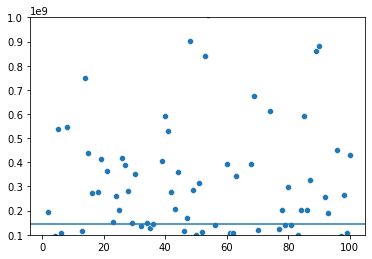

In [91]:
estimates_unsorted = [1/hash_val - 1 for hash_val in min_hashes_unsorted]
scatterplt = sns.scatterplot(x = list(range(1,101)),y = estimates_unsorted)
scatterplt.axhline(145000000)
plt.ylim([100000000,1000000000])

(10000000.0, 1000000000.0)

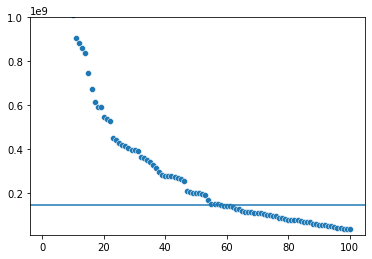

In [115]:
estimates_sorted = [1/hash_val - 1 for hash_val in min_hashes]
scatterplot_ = sns.scatterplot(x = list(range(1,101)),y = estimates_sorted)
scatterplot_.axhline(145000000)
plt.ylim([10000000,1000000000])

## Taking medians of 1,2,...n values and plotting

#### Plotting for unsorted values 

Text(0.5, 1.0, 'means of hash values')

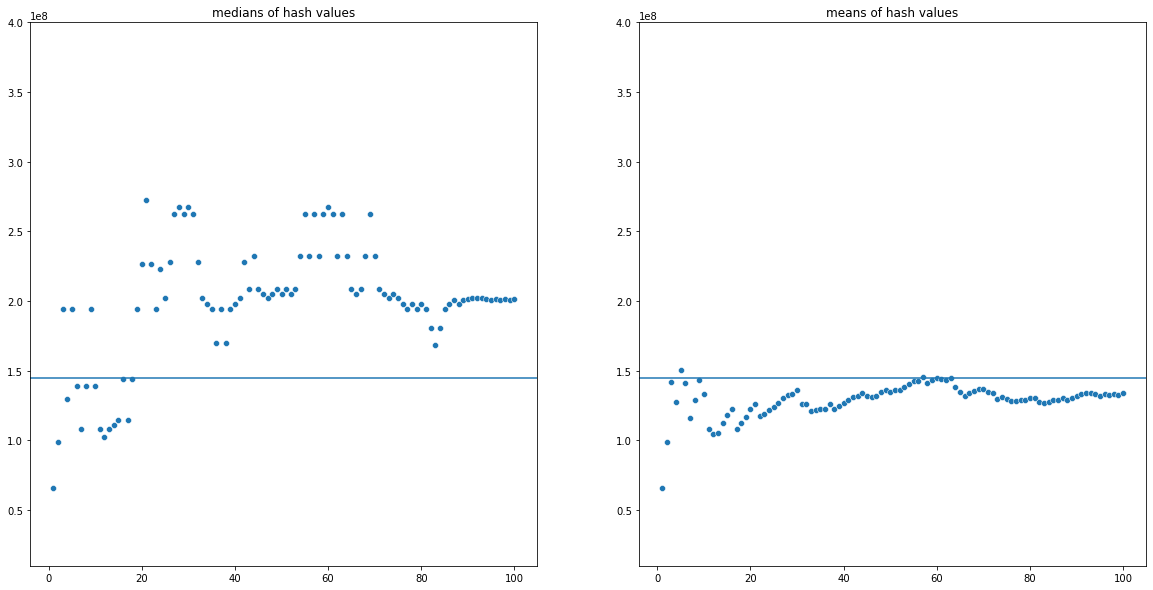

In [122]:
medians = [statistics.median(min_hashes_unsorted[0:i]) for i in range(1,101)]
estimates_medians = [1/median - 1 for median in medians]
avgs = [statistics.mean(min_hashes_unsorted[0:i]) for i in range(1,101)]
estimates_means = [1/avg - 1 for avg in avgs]
fig,axes = plt.subplots(nrows = 1,ncols = 2,figsize = (20,10))
scatterplot_median = sns.scatterplot(x = list(range(1,101)),y = estimates_medians,ax = axes[0])
scatterplot_median.axhline(145000000)
axes[0].set_ylim([10000000,400000000])
scatterplot_avg = sns.scatterplot(x = list(range(1,101)),y = estimates_means,ax = axes[1])
scatterplot_avg.axhline(145000000)
#145000000 is estimated number of unique elements
axes[1].set_ylim([10000000,400000000])
axes[0].set_title("medians of hash values")
axes[1].set_title("means of hash values")

#### Plotting for sorted values

Text(0.5, 1.0, 'means of sorted hash values')

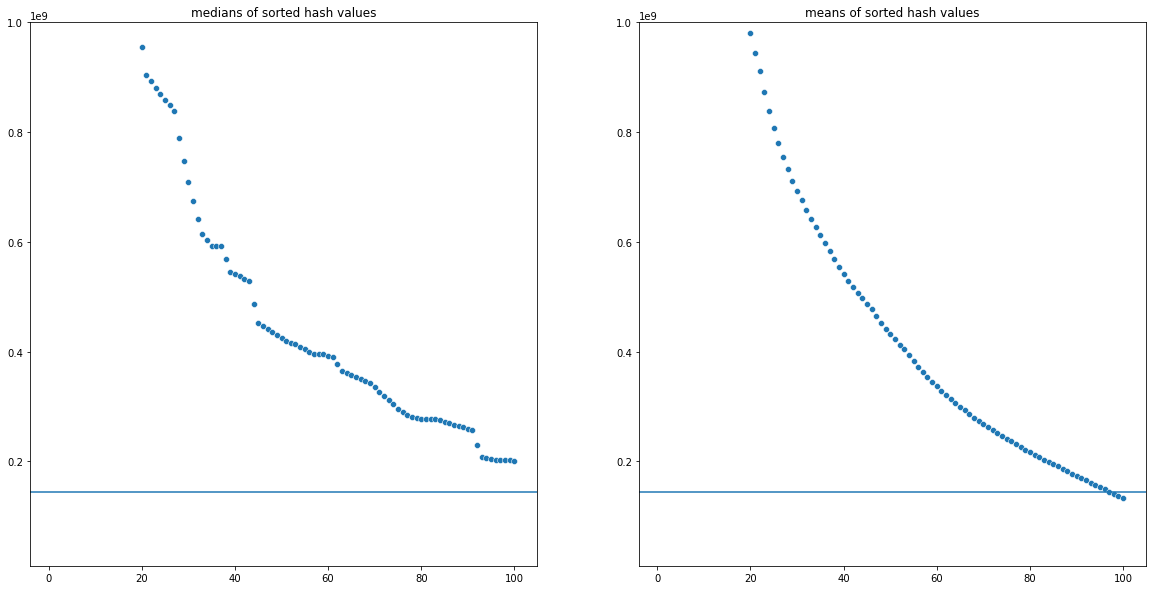

In [119]:
medians_avg = [statistics.median(min_hashes[0:i]) for i in range(1,101)]
estimates_medians_avg = [1/median - 1 for median in medians_avg]
avgs_sorted = [statistics.mean(min_hashes[0:i]) for i in range(1,101)]
estimates_means_avg = [1/avg - 1 for avg in avgs_sorted]
fig2,axes2 = plt.subplots(nrows = 1,ncols = 2,figsize = (20,10))
scatterplot_sorted_med = sns.scatterplot(x = list(range(1,101)),y = estimates_medians_avg,ax = axes2[0])
axes2[0].set_ylim([10000000,1000000000])
scatterplot_sorted_med.axhline(145000000)
scatterplot_sorted_avg = sns.scatterplot(x = list(range(1,101)),y = estimates_means_avg,ax = axes2[1])
scatterplot_sorted_avg.axhline(145000000)
axes2[1].set_ylim([10000000,1000000000])
axes2[0].set_title("medians of sorted hash values")
axes2[1].set_title("means of sorted hash values")
#145000000 is estimated number of unique elements

In [ ]:
# This will split input string at intervals of 15, incase less than 15 the smaller sequences will be added as well, will check for length of string while checking for double n.
# def get15mers(seq_,pos,interval = 15):
#     sequence_ = seq_[pos:]
#     query_regex = ".{1,"+str(interval)+"}"
#     lst_seq = re.findall(query_regex,sequence_)  ### credit to https://stackoverflow.com/questions/9475241/split-string-every-nth-character
#     return lst_seq

# lst_sample = get15mers(seq_string,0)

# arr_seq = []
# for i in tqdm(range(0,15)):
#     lst_ = get15mers(seq_string,i)
#     arr_seq.extend(lst_)

# lst_final = []
# for i in arr_seq:
#     if((len(i)<15) or (i.count("n")>2)):
#         #print(i)
#         pass
#     else:
#         #print(i)
#         lst_final.append(i)


